In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

# https://huggingface.co/blog/annotated-diffusion

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Convert to tensor and normalize between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
channels = 1
height = 28
width = 28

# Load mnist
mnist = MNIST('./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)



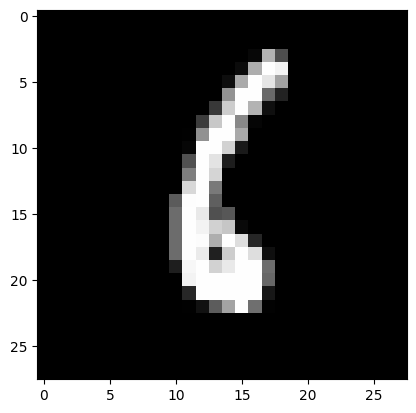

In [3]:
image = next(iter(data_loader))[0][0]
plt.imshow(image.squeeze(), cmap='gray');

In [4]:
T = 200
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

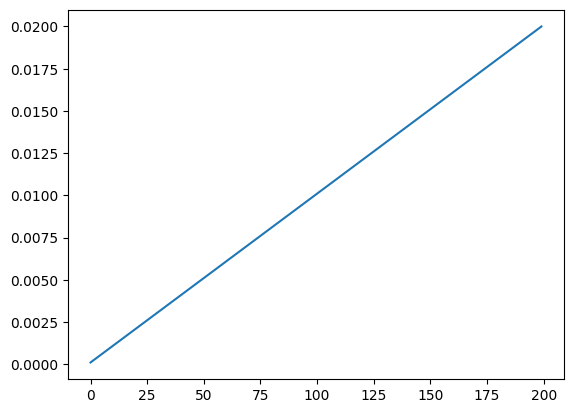

In [5]:
betas = linear_beta_schedule(T)
plt.plot(betas);

In [6]:
# Constant tensors used in sampling functions

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


torch.Size([1, 28, 28])
Noise step: 48


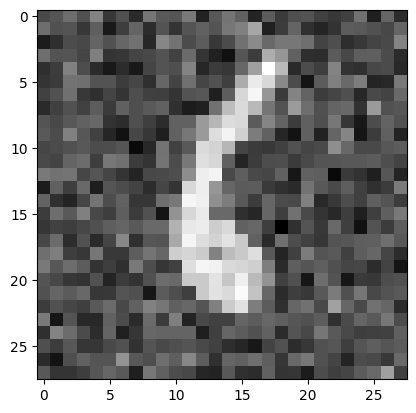

In [7]:
# Extract appropriate t index from batch of alphas (?)
def extract(a: torch.tensor, t: torch.tensor, x_shape: torch.tensor):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    
    return x_start * sqrt_alphas_cumprod_t + noise * sqrt_one_minus_alphas_cumprod_t

idx = torch.randint(0, T, (1,))
img_noisy = q_sample(image, torch.tensor([idx]))
print(img_noisy.shape)
print(f"Noise step: {idx.item()}")
plt.imshow(img_noisy.squeeze(), cmap='gray');

In [8]:
# Define some useful helper stuff

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return x + self.fn(x, *args, **kwargs)

def default(value, default):
    if value is not None:
        return value
    
    return default() if isfunction(default) else default

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1)

In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Class for time embedding a batch of time steps
    into a tensor of shape (batch_size, dim)
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.tensor, max_period: int = 10_000):
        # time: (batch_size,)
        # embeddings: (batch_size, dim)

        # assert time.dim() == 1

        device = time.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb


torch.Size([200])
torch.Size([200, 128])


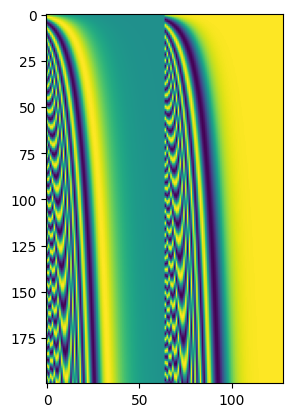

In [10]:
t = torch.arange(0, 200)
print(t.shape)
sinusoidal_embedding = SinusoidalPositionEmbeddings(128)
emb = sinusoidal_embedding(t)
print(emb.shape)

# plot the embeddings
plt.imshow(emb.detach().numpy());

In [11]:
# Blocks for U-net
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift: tuple = None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        return self.act(x)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()

        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim is not None
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):
        h = self.block1(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)


class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if time_emb_dim is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        # print(x.shape)
        h = self.ds_conv(x)
        # print(h.shape)

        if self.mlp is not None and time_emb is not None:
            # print("Time emb shape in ConvNext:", time_emb.shape)
            condition = self.mlp(time_emb)
            # print(condition.shape)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.head = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1) # Learn Q, K, V jointly
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.head), qkv
            )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
            )
    
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)



In [13]:
# Layer for computing groupnorm before a function fn
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [14]:
# Define U-net
# takes in a batch of images: (batch_size, channels, height, width)
# and returns a batch of images: (batch_size, channels, height, width)

# Conv on input + positional embeddings
# 2 x ConvNextBlock + GroupNorm + attention + residual + downsample x N
# middle: ConvNeXT + attention 
# decoding: 2 x ConvNextBlock + GroupNorm + attention + residual + upsample x N
# final: ConvNeXT + conv

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1,2,4,8),
        channels=1,
        resnet_block_groups=8,
        convnext_mult=2,
        use_convnext=False,
    ):
        super().__init__()

        self.channels = channels
        init_dim = init_dim if init_dim else dim // 3 * 2
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        # create list of dimensions for each block
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResBlock, groups=resnet_block_groups)

        # print("Using block class:", block_klass)
        # Time embedding
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # create list of blocks
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) # 'depth'

        # Downsample
        for i, (dim_in, dim_out) in enumerate(in_out):
            is_last = i >= num_resolutions - 1

            self.downs.append(
                nn.ModuleList([
                    block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                    block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                    Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                    Downsample(dim_out) if not is_last else nn.Identity(),
                ]))
        
        # Middle part
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        # Upsample
        for i, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = i >= num_resolutions - 1

            self.ups.append(
                nn.ModuleList([
                    block_klass(dim_out*2, dim_in, time_emb_dim=time_dim),
                    block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                    Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                    Upsample(dim_in) if not is_last else nn.Identity(),
                ]))
        
        # Output
        out_dim = out_dim if out_dim else channels
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1))

    def forward(self, x, time):

        # print("Input shape:", x.shape)
        # print("Time shape:", time.shape)
        x = self.init_conv(x)
        t = self.time_mlp(time)
        h = [] # skip connections?

        # Downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # Middle
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # Upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        
        return self.final_conv(x)

torch.Size([128, 1, 28, 28])
torch.Size([128])


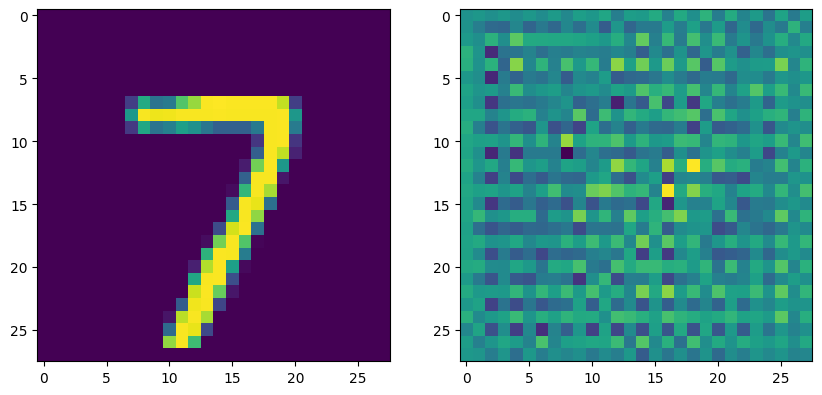

In [15]:
# call unet on image and time tensor


t = torch.randint(0, 100, (batch_size,))

x1 = next(iter(data_loader))[0]
print(x1.shape)
print(t.shape)

unet = Unet(
    dim=28,
    channels=channels,
    dim_mults=(1,2,4,),
    resnet_block_groups=7,
    use_convnext=False,
    )

out = unet(x1, t)

# plot x1 and out side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x1[0, 0, :, :].detach().numpy())
ax[1].imshow(out[0, 0, :, :].detach().numpy())

In [16]:
from torchinfo import summary
xsize = x1[0].size()
tsize = t[0].size()
# call summary on unet
summary(unet, [(128, 1, 28, 28), (128,)], depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [128, 1, 28, 28]          --
├─Conv2d: 1-1                                           [128, 18, 28, 28]         900
├─Sequential: 1-2                                       [128, 112]                --
│    └─SinusoidalPositionEmbeddings: 2-1                [128, 28]                 --
│    └─Linear: 2-2                                      [128, 112]                3,248
│    └─GELU: 2-3                                        [128, 112]                --
│    └─Linear: 2-4                                      [128, 112]                12,656
├─ModuleList: 1-3                                       --                        --
│    └─ModuleList: 2-5                                  --                        --
│    │    └─ResBlock: 3-1                               [128, 28, 28, 28]         15,456
│    │    └─ResBlock: 3-2                       

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):

    # Takes in list of (list of) tensor images (1, H, W) and plots them

    # print(type(imgs[0]))
    if isinstance(imgs[0], torch.Tensor):
      imgs = [img.view(img.shape[1], img.shape[2]).numpy() for img in imgs]
      
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [18]:
import numpy as np
image = next(iter(data_loader))[0][0]
print(image.shape)
T = 200
n_steps = 20
noised_ims = [q_sample(image, torch.tensor([t])) for t in np.linspace(0, T-1, n_steps, dtype=int)
]
print(noised_ims[0].shape)
plot(noised_ims)


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
Error in callback <function flush_figures at 0x7fd699a43b80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
def p_losses(model, x_start, t, noise=None, loss_type="l1"):
    """ Computes the loss for a given model and batch of imgs.
    Args:   x_start: the input image (batch_size, channels, height, width)
            t: the time (batch_size,)
            noise: the noise to add to the input image (batch_size, channels, height, width)
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = model(x_noisy, t)

    if loss_type == "l1":
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == "l2":
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise ValueError("Loss type not supported.")
    
    return loss

In [ ]:
im = next(iter(data_loader))[0]
print(im.shape)

out = p_losses(unet, im, t, loss_type="huber")
print(out)

In [ ]:
# Sampling during training

@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)

    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Predict mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    # If we're on last sample
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)

        return model_mean + noise * torch.sqrt(posterior_variance_t)

In [ ]:
tstep = torch.tensor([100])
x100 = q_sample(im, tstep)
print(x100.shape)


In [ ]:
pred = p_sample(unet, x100, t, 100)
print(pred.shape)
im_list = [x100[0, :, :, :], pred[0, :, :, :]]
im_list[0].shape
plot(im_list)

# No noticable difference because small number of steps and model is not trained

In [ ]:
# Full sampling loop from noise to image

@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]

    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, T)), desc="Sampling"):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=1):
    return p_sample_loop(model, (batch_size, channels, image_size, image_size))

In [ ]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)
save_and_sample_every = 1000

In [ ]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
unet.to(device)

optimizer = Adam(unet.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image
from tqdm import trange

epochs = 1

with trange(epochs) as pbar:
    for epoch in pbar:

        pbar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(data_loader):
            optimizer.zero_grad()

            # Actually loading images and labels now in data_loader...

            batch_size = batch[0].shape[0]
            batch = batch[0].to(device)

            # Sample t uniformally 
            t = torch.randint(0, T, (batch_size,), device=device).long()

            loss = p_losses(unet, batch, t, loss_type="huber")

            if step % 100 == 0:
                pbar.set_postfix(step=step, loss=loss.item())

            loss.backward()
            optimizer.step()

            # Save generated images
            if step != 0 and step % save_and_sample_every == 0:
                milestone = step // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(unet, batch_size=n), batches))
                all_images = torch.cat(all_images_list, dim=0)
                save_image(all_images, str(results_folder / f"sample_{milestone}.png"), nrow=6)
